In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

In [2]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [3]:
n_rotations = 30
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad

In [9]:
n_incs = 1000
n_spots = 3

In [10]:
inc_stellar = (180*np.random.rand(n_incs) - 90) * u.deg
spot_radii = np.array([0.2, 0.2, 0.2])[:, np.newaxis] * np.ones((n_spots, n_incs))
spot_lats = (20*np.random.rand(n_spots, n_incs) + 70) * u.deg
spot_lons = 360*np.random.rand(n_spots, n_incs) * u.deg

def lightcurve(spot_lons, spot_lats, spot_radii, inc_stellar):
    usr = UnitSphericalRepresentation(spot_lons, spot_lats) 
    cartesian = usr.represent_as(CartesianRepresentation)
    rotate = rotation_matrix(angles[:, np.newaxis, np.newaxis], axis='z')
    tilt = rotation_matrix(inc_stellar - 90*u.deg, axis='y')
    rotated_spot_positions = cartesian.transform(rotate)
    tilted_spot_positions = rotated_spot_positions.transform(tilt)

    r = np.ma.masked_array(np.sqrt(tilted_spot_positions.y**2 + tilted_spot_positions.z**2), 
                           mask=tilted_spot_positions.x < 0)
    ld = limb_darkening_normed(u_ld, r)

    f_spots = np.pi * spot_radii**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

    delta_f = (1 - np.sum(f_spots/f0, axis=1)).data
    return delta_f/delta_f.max(axis=0)

In [11]:
delta_f = lightcurve(spot_lons, spot_lats, spot_radii, inc_stellar)

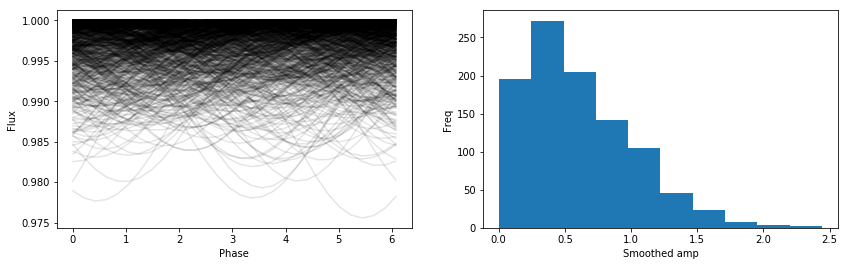

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(angles, delta_f, alpha=0.1, color='k')
ax[0].set(xlabel='Phase', ylabel='Flux')
ax[1].hist(100 * delta_f.ptp(axis=0))
ax[1].set(xlabel='Smoothed amp', ylabel='Freq')
plt.show()